This notebook is used for analysis of the bftt species composition sims. Should also be able to be repurposed for the multispecies stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import matplotlib.pylab as pl
from itertools import cycle
import matplotlib.gridspec as gridspec
import glob


In [159]:
nRuns = 100 #reduced to 10 for now to speed things up
duration = 100.
nSamples = 50

phase2_filepath = "speciesComp-phase2-fixedImm-bigK//geno_distbs"
phase4_filepath = "speciesComp-phase4-fixedImm-bigK//geno_distbs"

phase2_mh_times = pd.read_csv("speciesComp-phase2-fixedImm-bigK/rIm-0.5_rDet-0.25-microhabs_over_time.csv")
phase2_mh_times = phase2_mh_times.drop(columns=['t'])
phase2_mh_times = phase2_mh_times.add_prefix("run_")
phase2_mh_times['avg_mh_t'] = phase2_mh_times.mean(axis=1)
phase2_mh_times['std_mh_t'] = phase2_mh_times.std(axis=1)
#phase2_mh_times

phase4_mh_times = pd.read_csv("speciesComp-phase4-fixedImm-bigK/rIm-0.5_rDet-1.0-microhabs_over_time.csv")
phase4_mh_times = phase4_mh_times.drop(columns=['t'])
phase4_mh_times = phase4_mh_times.add_prefix("run_")
phase4_mh_times['avg_mh_t'] = phase4_mh_times.mean(axis=1)
phase4_mh_times['std_mh_t'] = phase4_mh_times.std(axis=1)
phase4_mh_times
# phase2_mh_times = phase2_mh_times.add_prefix("run_")

# phase2_mh_times.rename(columns={'run_t':'t'}, inplace=True)

# # new_header = phase2_mh_times.iloc[0] #grab the first row for the header
# # phase2_mh_times = phase2_mh_times[1:] #take the data less the header row
# # phase2_mh_times.columns = new_header #set the header row as the df header
# phase2_mh_times

,run_ 0,run_ 1,run_ 2,run_ 3,run_ 4,run_ 5,run_ 6,run_ 7,run_ 8,run_ 9,...,run_ 92,run_ 93,run_ 94,run_ 95,run_ 96,run_ 97,run_ 98,run_ 99,avg_mh_t,std_mh_t
0,43.125,38.975,36.925,30.875,33.100,35.925,38.2,38.8625,41.0500,38.7500,...,45.4500,43.325,34.400,38.025,34.900,38.600,37.000,37.575,39.926625,3.819252
1,68.025,61.825,62.025,56.675,55.675,59.300,62.2,63.5375,65.9250,63.7250,...,70.7750,67.175,58.025,59.875,58.175,62.650,61.025,60.750,63.782375,4.071612
2,91.950,83.300,84.525,80.300,80.825,81.800,82.8,85.5125,88.1625,87.1875,...,95.2875,90.975,79.775,82.975,81.000,88.125,82.425,85.250,86.495625,4.100746


In [9]:
def readGenoDistbsFromFile(filepath, nRuns, duration, nSamples):
    '''
    This method reads in the geno distributions for each timestep for each run.
    Inside the geno_distbs directory there are directories for each of the runs, in the for runID_NN.
    Inside each of the runID directories there are several csv files, which contain the geno distributions over the microhabitats for several time samples.
    These geno distributions have the format of each line containing the genotypes present in each microhabitat.
    Each line is a seperate microhabitat, need to "transpose" the dataframe once it's read in.
    
    Returns: a dictionary where each key is the run_ID, and each entry is another dictionary - 
    The keys in these subdictionaries are the time values, and the entries in these subdictionaries are dataframes with each column being the genotypes in each microhabitat.
    
    TODO - AS THERE MAY NOT BE 100 SAMPLES FOR SOME OF THESE, NEED TO FIGURE OUT HOW TO ITERATE THROUGH THE FILES IN THE FOLDER
    TODO - AND READ THEM DIRECTLY, THEN ALSO SAVE THE TIMES IN THE FILE NAMES AS THE TIME KEYS
    TODO - I THINK I DID THIS IN MY OLD MULTISPECIES ANALYSIS CODE
    '''
    
    interval = duration/nSamples #time between samples
    runID_dict = {} #dictionary containg all of the runs, the IDs are the keys
    
    #iterate over all the runs
    for rID in range(nRuns):
        runID_key = "runID_"+str(rID)
        print(runID_key)
        filepath_runID = filepath+"/"+runID_key
        time_dict = {} #dictionary containing geno dataframes for each timestep
        
        #iterate over all the times
        '''CUT OFF SOME OF THE LATER ONES HERE DUE TO SOME SIMULATIONS ENDING EARLY (THICKNESS LIMIT REACHED)'''
        for t in range(0, nSamples-4):
            
            time_val = interval*t
            #print(time_val)
            
            #need to use wildcard for the time, as the decimal values vary slightly between runs
            #glob helps with this
            time_key = "t="+str(int(time_val))
            filepath_time = filepath_runID+"/geno_distb-"+time_key+".*.csv"
            #print(filepath_time)
            
#             print(filepath_time)
            #print(glob.glob(filepath_time)[0])
            filename = glob.glob(filepath_time)[0]
            
            #need to swap the rows and columns so that the microhabitat is the key in the dataframe
            #geno_df = pd.read_csv(filename, header=None).T
            geno_df = pd.DataFrame([line.strip().split(',') for line in open(filename, 'r')]).T
            #geno
            new_header = geno_df.iloc[0] #grab the first row for the header
            geno_df = geno_df[1:] #take the data less the header row
            geno_df.columns = new_header #set the header row as the df header
            
            geno_df = geno_df.astype(float)
            
            time_dict[time_key] = geno_df
            
        
        runID_dict[runID_key] = time_dict
        
    return runID_dict
  

In [150]:
phase4_data = readGenoDistbsFromFile(phase4_filepath, nRuns, duration, nSamples)

runID_0
runID_1
runID_2
runID_3
runID_4
runID_5
runID_6
runID_7
runID_8
runID_9
runID_10
runID_11
runID_12
runID_13
runID_14
runID_15
runID_16
runID_17
runID_18
runID_19
runID_20
runID_21
runID_22
runID_23
runID_24
runID_25
runID_26
runID_27
runID_28
runID_29
runID_30
runID_31
runID_32
runID_33
runID_34
runID_35
runID_36
runID_37
runID_38
runID_39
runID_40
runID_41
runID_42
runID_43
runID_44
runID_45
runID_46
runID_47
runID_48
runID_49
runID_50
runID_51
runID_52
runID_53
runID_54
runID_55
runID_56
runID_57
runID_58
runID_59
runID_60
runID_61
runID_62
runID_63
runID_64
runID_65
runID_66
runID_67
runID_68
runID_69
runID_70
runID_71
runID_72
runID_73
runID_74
runID_75
runID_76
runID_77
runID_78
runID_79
runID_80
runID_81
runID_82
runID_83
runID_84
runID_85
runID_86
runID_87
runID_88
runID_89
runID_90
runID_91
runID_92
runID_93
runID_94
runID_95
runID_96
runID_97
runID_98
runID_99


In [151]:

phase2_data = readGenoDistbsFromFile(phase2_filepath, nRuns=nRuns, duration=duration, nSamples=nSamples)

runID_0
runID_1
runID_2
runID_3
runID_4
runID_5
runID_6
runID_7
runID_8
runID_9
runID_10
runID_11
runID_12
runID_13
runID_14
runID_15
runID_16
runID_17
runID_18
runID_19
runID_20
runID_21
runID_22
runID_23
runID_24
runID_25
runID_26
runID_27
runID_28
runID_29
runID_30
runID_31
runID_32
runID_33
runID_34
runID_35
runID_36
runID_37
runID_38
runID_39
runID_40
runID_41
runID_42
runID_43
runID_44
runID_45
runID_46
runID_47
runID_48
runID_49
runID_50
runID_51
runID_52
runID_53
runID_54
runID_55
runID_56
runID_57
runID_58
runID_59
runID_60
runID_61
runID_62
runID_63
runID_64
runID_65
runID_66
runID_67
runID_68
runID_69
runID_70
runID_71
runID_72
runID_73
runID_74
runID_75
runID_76
runID_77
runID_78
runID_79
runID_80
runID_81
runID_82
runID_83
runID_84
runID_85
runID_86
runID_87
runID_88
runID_89
runID_90
runID_91
runID_92
runID_93
runID_94
runID_95
runID_96
runID_97
runID_98
runID_99


In [16]:
#testo["runID_0"]["t=0"]["mh_0"] = pd.to_numeric(testo["runID_0"]["t=0"]["mh_0"])
phase2_data["runID_0"]['t=92'].keys()

Index(['mh_0', 'mh_1', 'mh_2', 'mh_3', 'mh_4', 'mh_5', 'mh_6', 'mh_7'], dtype='object', name=0)

In [14]:
def getStandardDeviationOfInnerMicrohab(dataset):
    '''
    This takes in the big dataset of all the runs.
    Plots the standard deviation of the genotypes in microhabitat 0 over time for all the runs
    
    '''
    interval = duration/nSamples
    #microhab_key = "mh_0"
    for r in range(nRuns):
        
        run_key = "runID_"+str(r)
        geno_stDev = []
        times = []
        
        for t in range(4, nSamples-4):
            t_val = t*interval
            times.append(t_val)
            time_key = "t="+str(int(t_val))
            
            microhab_key = dataset[run_key][time_key].keys()[-1]
            #print(t_val)
            dataset[run_key][time_key][microhab_key] = pd.to_numeric(dataset[run_key][time_key][microhab_key])
            geno_stDev.append(dataset[run_key][time_key][microhab_key].std())
            
        plt.plot(times, geno_stDev)
    
    plt.show()
        
    

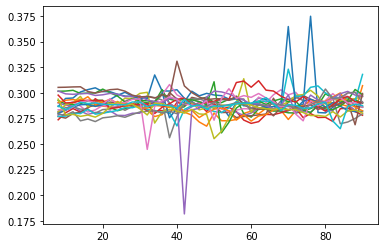

In [15]:
getStandardDeviationOfInnerMicrohab(phase4_data)

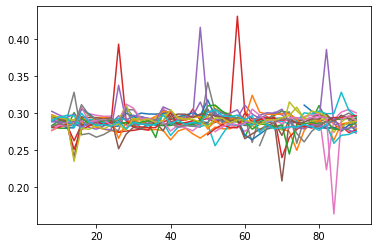

In [16]:
getStandardDeviationOfInnerMicrohab(phase2_data)

In [41]:
def getVarianceOverTime(phase2_data, phase4_data):
    '''
    Alternate version of plotting the variance of the populations for each parameter phase.
    Here for each timestep, we find the standard deviation of the geno distb in mh_0 of each run,
    then find the standard deviation of these standard deviations (call this V)
    
    we then plot V over time
    '''
    
    times = []
    V_phase_2 = []
    V_phase_4 = []
    
    interval = duration/nSamples
    microhab_key = "mh_0"
    
    for t in range(4, nSamples-4):
        t_val = t*interval
        times.append(t_val)
        time_key = "t="+str(int(t_val))
        
        phase2_stdev = []
        phase4_stdev = []
        
        for r in range(nRuns):
            run_key = "runID_"+str(r)
            phase2_data[run_key][time_key][microhab_key] = pd.to_numeric(phase2_data[run_key][time_key][microhab_key])
            phase4_data[run_key][time_key][microhab_key] = pd.to_numeric(phase4_data[run_key][time_key][microhab_key])
            
            phase2_stdev.append(phase2_data[run_key][time_key][microhab_key].std())
            phase4_stdev.append(phase4_data[run_key][time_key][microhab_key].std())
            
        
        V_phase_2.append(np.mean(np.array(phase2_stdev)))
        V_phase_4.append(np.mean(np.array(phase4_stdev)))
    
    
    plt.plot(times, V_phase_2, label="phase 2")
    plt.plot(times, V_phase_4, label="phase 4")
    plt.legend()
    plt.show()


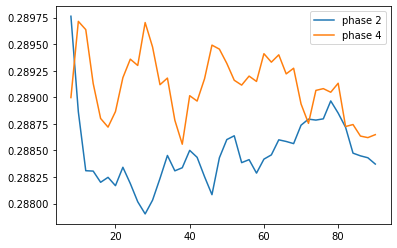

In [42]:
getVarianceOverTime(phase2_data=phase2_data, phase4_data=phase4_data)

In [166]:
def getStDevOfEdgeMicrohabitat(phase2_data, phase4_data):
    
    '''
    This takes in the big datasets for both of the parameter sets.
    
    For each timestep it gets the standard deviation of the edge microhabitat
    then plots the average of these for all the runs.
    
    For now, let's hope that the final key in the .keys() list is the edge microhabitat
    Can think of a better way to check later
    
    '''
    times = []
    V_phase_2 = []
    V_phase_4 = []
    
    interval = duration/nSamples
    #microhab_key = "mh_0"
    
    for t in range(4, nSamples-4):
        t_val = t*interval
        times.append(t_val)
        time_key = "t="+str(int(t_val))
        
        phase2_stdev = []
        phase4_stdev = []
        
        for r in range(nRuns):
            run_key = "runID_"+str(r)
            
            p2_mh_key = phase2_data[run_key][time_key].keys()[-1] #gets the last key in the list of keys (hopefully it's the edge one)
            #print(p2_mh_key)
            p4_mh_key = phase4_data[run_key][time_key].keys()[-1] 
            
            phase2_stdev.append(np.nanstd(phase2_data[run_key][time_key][p2_mh_key]))
            phase4_stdev.append(np.nanstd(phase4_data[run_key][time_key][p4_mh_key]))

#             print(np.nanstd(phase2_data[run_key][time_key][p2_mh_key]))
#             print(phase2_data[run_key][time_key][p2_mh_key].size)
            
            
# #             p2_mh_key = phase2_data[run_key][time_key].stack().std()  #gets the last key in the list of keys (hopefully it's the edge one)
# #             p4_mh_key = phase4_data[run_key][time_key].stack().std()  #gets the last key in the list of keys (hopefully it's the edge one)

            
# #             phase2_data[run_key][time_key][p2_mh_key] = pd.to_numeric(phase2_data[run_key][time_key][p2_mh_key])
# #             phase4_data[run_key][time_key][p4_mh_key] = pd.to_numeric(phase4_data[run_key][time_key][p4_mh_key])

            
# #             phase2_stdev.append(phase2_data[run_key][time_key][p2_mh_key].mean(skipna=True))
# #             #print(phase2_data[run_key][time_key][p2_mh_key].std())
# #             phase4_stdev.append(phase4_data[run_key][time_key][p4_mh_key].mean())
# '''SOME OF THESE LISTS HAVE NANS IN THEM FOR SOME REASON, NEED TO REMOVE THEM MIGHT BE DUE TO MISSING ELEMENTS'''
#             print(phase2_data[run_key][time_key].values)
#             phase2_stdev.append(phase2_data[run_key][time_key].values.std(ddof=1))
            
#             print(phase2_data[run_key][time_key].values.std(ddof=1))
#             phase4_stdev.append(phase4_data[run_key][time_key].values.std(ddof=1))
        
        V_phase_2.append(np.nanstd(np.array(phase2_stdev), ddof=1)/np.nanmean(np.array(phase2_stdev)))
        V_phase_4.append(np.nanstd(np.array(phase4_stdev), ddof=1)/np.nanmean(np.array(phase4_stdev)))
#         V_phase_2.append(np.nanmean(np.array(phase2_stdev)))
#         V_phase_4.append(np.nanmean(np.array(phase4_stdev)))
    
    plt.figure(figsize=(8,6))
    
    plt.plot(times, V_phase_2, label="phase 2", lw=2.4)
    plt.plot(times, V_phase_4, label="phase 4", lw=2.4)
    
    y2 = [0.02 for i in range(len(phase2_mh_times[:-1]))]
    y4 = [0.015 for i in range(len(phase4_mh_times[:]))]
    
    plt.plot(phase2_mh_times['avg_mh_t'][:-1], y2, "s", lw=4, markeredgewidth=1.5, markeredgecolor="k", label="phase2 new microhabs")
    plt.plot(phase4_mh_times['avg_mh_t'][:], y4, "s", lw=4, markeredgewidth=1.5, markeredgecolor="k", label="phase4 new microhabs")

    #plt.scatter(phase4_mh_times['avg_mh_t'][:-1], y4, lw=4, edgecolors='k', markeredgewidth=1.2)
    plt.xlabel("t", fontsize=18)
    plt.ylabel("CV(stDev)", fontsize=18)
    plt.title("variances of the edge microhabitat", fontsize=20)
    plt.legend()
    plt.savefig("edge_variances_bigK.pdf", bbox_inches="tight")
    plt.show()

/home/patrick/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


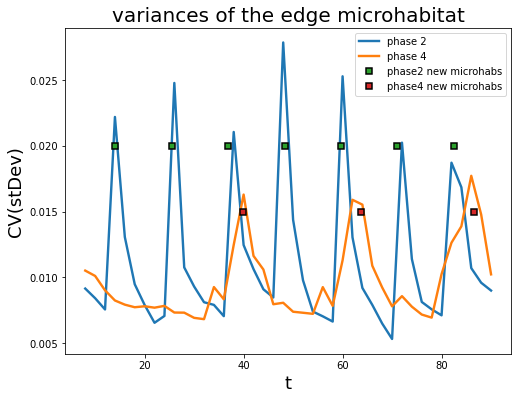

In [167]:
getStDevOfEdgeMicrohabitat(phase2_data=phase2_data, phase4_data=phase4_data)

In [ ]:
filename = glob.glob(testpath+"96*", )[0]
df = pd.read_csv(filename, header=None).T



df
df['mh_1']

In [ ]:
df = pd.DataFrame([line.strip().split(',') for line in open('speciesComp-phase2-fixedImm-bigK/geno_distbs/runID_0/geno_distb-t=74.05.csv', 'r')]).T
df